# YOLOV8预训练模型预测-Python API-摄像头实时画面

同济子豪兄 2023-4-25

## `注意，本代码需要在本地，连接摄像头运行，不能在云GPU平台运行`

## 导入工具包

In [29]:
import cv2
import numpy as np
import time
from tqdm import tqdm

from ultralytics import YOLO

import matplotlib.pyplot as plt
%matplotlib inline 

## 载入模型

In [30]:
# 载入预训练模型
model = YOLO('yolov8n-pose.pt')
# model = YOLO('yolov8s-pose.pt')
# model = YOLO('yolov8m-pose.pt')
# model = YOLO('yolov8l-pose.pt')
# model = YOLO('yolov8x-pose.pt')
# model = YOLO('yolov8x-pose-p6.pt')

## 可视化配置

In [31]:
# 框（rectangle）可视化配置
bbox_color = (150, 0, 0)             # 框的 BGR 颜色
bbox_thickness = 2                   # 框的线宽

# 框类别文字
bbox_labelstr = {
    'font_size':1,         # 字体大小
    'font_thickness':2,   # 字体粗细
    'offset_x':0,          # X 方向，文字偏移距离，向右为正
    'offset_y':-10,       # Y 方向，文字偏移距离，向下为正
}

In [32]:
# 关键点 BGR 配色
kpt_color_map = {
    0:{'name':'Nose', 'color':[0, 0, 255], 'radius':6},                # 鼻尖
    1:{'name':'Right Eye', 'color':[255, 0, 0], 'radius':6},           # 右边眼睛
    2:{'name':'Left Eye', 'color':[255, 0, 0], 'radius':6},            # 左边眼睛
    3:{'name':'Right Ear', 'color':[0, 255, 0], 'radius':6},           # 右边耳朵
    4:{'name':'Left Ear', 'color':[0, 255, 0], 'radius':6},            # 左边耳朵
    5:{'name':'Right Shoulder', 'color':[193, 182, 255], 'radius':6},  # 右边肩膀
    6:{'name':'Left Shoulder', 'color':[193, 182, 255], 'radius':6},   # 左边肩膀
    7:{'name':'Right Elbow', 'color':[16, 144, 247], 'radius':6},      # 右侧胳膊肘
    8:{'name':'Left Elbow', 'color':[16, 144, 247], 'radius':6},       # 左侧胳膊肘
    9:{'name':'Right Wrist', 'color':[1, 240, 255], 'radius':6},       # 右侧手腕
    10:{'name':'Left Wrist', 'color':[1, 240, 255], 'radius':6},       # 左侧手腕
    11:{'name':'Right Hip', 'color':[140, 47, 240], 'radius':6},       # 右侧胯
    12:{'name':'Left Hip', 'color':[140, 47, 240], 'radius':6},        # 左侧胯
    13:{'name':'Right Knee', 'color':[223, 155, 60], 'radius':6},      # 右侧膝盖
    14:{'name':'Left Knee', 'color':[223, 155, 60], 'radius':6},       # 左侧膝盖
    15:{'name':'Right Ankle', 'color':[139, 0, 0], 'radius':6},        # 右侧脚踝
    16:{'name':'Left Ankle', 'color':[139, 0, 0], 'radius':6},         # 左侧脚踝
}

# 骨架连接 BGR 配色
skeleton_map = [
    {'srt_kpt_id':15, 'dst_kpt_id':13, 'color':[0, 100, 255], 'thickness':2},       # 右侧脚踝-右侧膝盖
    {'srt_kpt_id':13, 'dst_kpt_id':11, 'color':[0, 255, 0], 'thickness':2},         # 右侧膝盖-右侧胯
    {'srt_kpt_id':16, 'dst_kpt_id':14, 'color':[255, 0, 0], 'thickness':2},         # 左侧脚踝-左侧膝盖
    {'srt_kpt_id':14, 'dst_kpt_id':12, 'color':[0, 0, 255], 'thickness':2},         # 左侧膝盖-左侧胯
    {'srt_kpt_id':11, 'dst_kpt_id':12, 'color':[122, 160, 255], 'thickness':2},     # 右侧胯-左侧胯
    {'srt_kpt_id':5, 'dst_kpt_id':11, 'color':[139, 0, 139], 'thickness':2},        # 右边肩膀-右侧胯
    {'srt_kpt_id':6, 'dst_kpt_id':12, 'color':[237, 149, 100], 'thickness':2},      # 左边肩膀-左侧胯
    {'srt_kpt_id':5, 'dst_kpt_id':6, 'color':[152, 251, 152], 'thickness':2},       # 右边肩膀-左边肩膀
    {'srt_kpt_id':5, 'dst_kpt_id':7, 'color':[148, 0, 69], 'thickness':2},          # 右边肩膀-右侧胳膊肘
    {'srt_kpt_id':6, 'dst_kpt_id':8, 'color':[0, 75, 255], 'thickness':2},          # 左边肩膀-左侧胳膊肘
    {'srt_kpt_id':7, 'dst_kpt_id':9, 'color':[56, 230, 25], 'thickness':2},         # 右侧胳膊肘-右侧手腕
    {'srt_kpt_id':8, 'dst_kpt_id':10, 'color':[0,240, 240], 'thickness':2},         # 左侧胳膊肘-左侧手腕
    {'srt_kpt_id':1, 'dst_kpt_id':2, 'color':[224,255, 255], 'thickness':2},        # 右边眼睛-左边眼睛
    {'srt_kpt_id':0, 'dst_kpt_id':1, 'color':[47,255, 173], 'thickness':2},         # 鼻尖-左边眼睛
    {'srt_kpt_id':0, 'dst_kpt_id':2, 'color':[203,192,255], 'thickness':2},         # 鼻尖-左边眼睛
    {'srt_kpt_id':1, 'dst_kpt_id':3, 'color':[196, 75, 255], 'thickness':2},        # 右边眼睛-右边耳朵
    {'srt_kpt_id':2, 'dst_kpt_id':4, 'color':[86, 0, 25], 'thickness':2},           # 左边眼睛-左边耳朵
    {'srt_kpt_id':3, 'dst_kpt_id':5, 'color':[255,255, 0], 'thickness':2},          # 右边耳朵-右边肩膀
    {'srt_kpt_id':4, 'dst_kpt_id':6, 'color':[255, 18, 200], 'thickness':2}         # 左边耳朵-左边肩膀
]

## 逐帧处理函数

In [33]:
def process_frame(img_bgr):
    
    '''
    输入摄像头画面 bgr-array，输出图像 bgr-array
    '''
    
    # 记录该帧开始处理的时间
    start_time = time.time()
    
    results = model(img_bgr)
    
    # 预测框的个数
    num_bbox = len(results[0].boxes.cls)
    
    # 预测框的 xyxy 坐标
    bboxes_xyxy = results[0].boxes.xyxy.cpu().numpy().astype('uint32') 
    
    # 关键点的 xy 坐标
    bboxes_keypoints = results[0].keypoints.cpu().numpy().astype('uint32')
    
    for idx in range(num_bbox): # 遍历每个框

        # 获取该框坐标
        bbox_xyxy = bboxes_xyxy[idx] 

        # 获取框的预测类别（对于关键点检测，只有一个类别）
        bbox_label = results[0].names[0]

        # 画框
        img_bgr = cv2.rectangle(img_bgr, (bbox_xyxy[0], bbox_xyxy[1]), (bbox_xyxy[2], bbox_xyxy[3]), bbox_color, bbox_thickness)

        # 写框类别文字：图片，文字字符串，文字左上角坐标，字体，字体大小，颜色，字体粗细
        img_bgr = cv2.putText(img_bgr, bbox_label, (bbox_xyxy[0]+bbox_labelstr['offset_x'], bbox_xyxy[1]+bbox_labelstr['offset_y']), cv2.FONT_HERSHEY_SIMPLEX, bbox_labelstr['font_size'], bbox_color, bbox_labelstr['font_thickness'])

        bbox_keypoints = bboxes_keypoints[idx] # 该框所有关键点坐标和置信度

        # 画该框的骨架连接
        for skeleton in skeleton_map:

            # 获取起始点坐标
            srt_kpt_id = skeleton['srt_kpt_id']
            srt_kpt_x = bbox_keypoints[srt_kpt_id][0]
            srt_kpt_y = bbox_keypoints[srt_kpt_id][1]

            # 获取终止点坐标
            dst_kpt_id = skeleton['dst_kpt_id']
            dst_kpt_x = bbox_keypoints[dst_kpt_id][0]
            dst_kpt_y = bbox_keypoints[dst_kpt_id][1]

            # 获取骨架连接颜色
            skeleton_color = skeleton['color']

            # 获取骨架连接线宽
            skeleton_thickness = skeleton['thickness']

            # 画骨架连接
            img_bgr = cv2.line(img_bgr, (srt_kpt_x, srt_kpt_y),(dst_kpt_x, dst_kpt_y),color=skeleton_color,thickness=skeleton_thickness)

        # 画该框的关键点
        for kpt_id in kpt_color_map:
            kpt_color = kpt_color_map[kpt_id]['color']
            kpt_radius = kpt_color_map[kpt_id]['radius']
            kpt_x = bbox_keypoints[kpt_id][0]
            kpt_y = bbox_keypoints[kpt_id][1]
            img_bgr = cv2.circle(img_bgr, (kpt_x, kpt_y), kpt_radius, kpt_color, -1)
            
    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time - start_time)

    # 在画面上写字：图片，字符串，左上角坐标，字体，字体大小，颜色，字体粗细
    FPS_string = 'FPS  '+str(int(FPS)) # 写在画面上的字符串
    img_bgr = cv2.putText(img_bgr, FPS_string, (25, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255, 0, 255), 2)
    
    return img_bgr

## 摄像头拍摄单帧画面

In [44]:
# 获取摄像头，0为电脑默认摄像头，1为外接摄像头
cap = cv2.VideoCapture(0)

# 拍照
time.sleep(3) # 运行本代码后等几秒拍照
# 从摄像头捕获一帧画面
success, frame = cap.read()

cap.release() # 关闭摄像头
cv2.destroyAllWindows() # 关闭图像窗口

In [45]:
frame.shape

(720, 1280, 3)

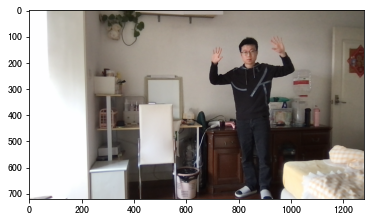

In [46]:
plt.imshow(frame[:,:,::-1])
plt.show()

## 单帧画面关键点检测预测


0: 384x640 1 person, 118.4ms
Speed: 0.8ms preprocess, 118.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


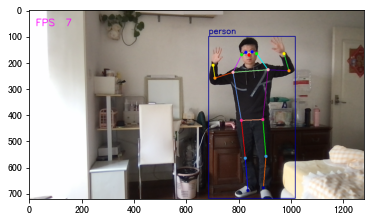

In [47]:
img_bgr = process_frame(frame)

plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 摄像头实时画面逐帧处理（模板）

In [48]:
# 调用摄像头逐帧实时处理模板
# 不需修改任何代码，只需修改process_frame函数即可
# 同济子豪兄 2021-7-8

# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

# 无限循环，直到break被触发
while cap.isOpened():
    
    # 获取画面
    success, frame = cap.read()
    
    if not success: # 如果获取画面不成功，则退出
        print('获取画面不成功，退出')
        break
    
    ## 逐帧处理
    frame = process_frame(frame)
    
    # 展示处理后的三通道图像
    cv2.imshow('my_window',frame)
    
    key_pressed = cv2.waitKey(60) # 每隔多少毫秒毫秒，获取键盘哪个键被按下
    # print('键盘上被按下的键：', key_pressed)

    if key_pressed in [ord('q'),27]: # 按键盘上的q或esc退出（在英文输入法下）
        break
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

## 按`q`键或`Esc`键关闭画面